# Collaboration and Competition

---


### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. Implementation

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

# -------------------------------------------------------------------------------------------------------------

# Deep Neural Networks

In [6]:
import random
import numpy as np
import pandas as pd
import matplotlib as plt
import copy
from collections import namedtuple, deque
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,7)})

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128, lr=0.002):

        super(Actor, self).__init__()
        self.state_size = state_size
        self.seed = torch.manual_seed(seed)

        self.bn1 = nn.BatchNorm1d(state_size)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.dr1 = nn.Dropout(p=0.0)

        self.bn2 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.dr2 = nn.Dropout(p=0.0)

        self.bn3 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.dr3 = nn.Dropout(p=0.0)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.to(device)
        
        self.reset_parameters()

        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        
        if len(state) == self.state_size:
            state = state.unsqueeze(0)
        
        x = self.dr1(F.relu(self.fc1(self.bn1(state))))
        x = self.dr2(F.relu(self.fc2(self.bn2(x))))
        return self.dr3(F.tanh(self.fc3(self.bn3(x))))
        

class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128, lr=0.002):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bns = nn.BatchNorm1d(fcs1_units)

        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.dr1 = nn.Dropout(p=0.0)
        self.fc3 = nn.Linear(fc2_units, 1)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=0)
        self.loss = nn.MSELoss()
        self.to(device)
                
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.relu(self.fcs1(state))
        xs = self.bns(xs)
        x = torch.cat((xs, action), dim=1)
        x = self.dr1(F.relu(self.fc2(x)))
        return self.fc3(x)


# Replay Buffer

In [8]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

# OUNoise

In [9]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.normal(0, 1, self.size)
        self.state = x + dx
        return self.state

# Agent

In [13]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 2e-3         # learning rate of the actor 
LR_CRITIC = 2e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

ACTOR_UNITS_l1 = 128    # DNN layers units
ACTOR_UNITS_l2 = 128
CRITIC_UNITS_l1 = 128
CRITIC_UNITS_l2 = 128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agents():
    
    def __init__(self, state_size, action_size, num_agents, random_seed):

        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)

        # Actor Network
        self.actor_local = Actor(state_size, action_size, random_seed, ACTOR_UNITS_l1, ACTOR_UNITS_l2, lr=LR_ACTOR).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed, ACTOR_UNITS_l1, ACTOR_UNITS_l2, lr=LR_ACTOR).to(device)

        # Critic Network
        self.critic_local = Critic(state_size, action_size, random_seed, CRITIC_UNITS_l1, CRITIC_UNITS_l2, lr=LR_CRITIC).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, CRITIC_UNITS_l1, CRITIC_UNITS_l2, lr=LR_CRITIC).to(device)
        
        self.noise = OUNoise((num_agents, action_size), random_seed)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    

    def step(self, states, actions, rewards, next_states, dones):
 
        for i in range(self.num_agents):
            self.memory.add(states[i,:], actions[i,:], rewards[i], next_states[i,:], dones[i])

        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, states, add_noise=True):
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        
        self.actor_local.eval()
        with torch.no_grad():
            for num, state in enumerate(states):
                actions[num,:] = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            actions += self.noise.sample()
        return np.clip(actions, -1, 1)

    def reset_noise(self):
        self.noise.reset()

    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- CRITIC ---------------------------- #
         # 1) Calculate Y for target
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)

        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # 2) Process critic backpropagation
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        self.critic_local.optimizer.zero_grad()
        critic_loss.backward()
        self.critic_local.optimizer.step()

        # ---------------------------- ACTOR ---------------------------- #
        # 3) Process actor backpropagation
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        self.actor_local.optimizer.zero_grad()
        actor_loss.backward()
        self.actor_local.optimizer.step()

        # 4) Update target networks parameters
        self.update(self.critic_local, self.critic_target, TAU)
        self.update(self.actor_local, self.actor_target, TAU) 
                    

    def update(self, local_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    def save_model(self):
        torch.save(self.actor_local.state_dict(), 'trained_actor_model.pth')
        torch.save(self.critic_local.state_dict(), 'trained_critic_model.pth')
        
    def load_model(self):
        self.actor_local.load_state_dict(torch.load('trained_actor_model.pth'))
        self.actor_local.eval()
        self.critic_local.load_state_dict(torch.load('trained_critic_model.pth'))
        self.critic_local.eval()

In [25]:
GAMES = 3000
samples = 100

scores_deque = deque(maxlen=samples)
scores = []
average = []

agents = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

for episode in range(1, GAMES+1):
    
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    
    agents.reset_noise()
    score = np.zeros(num_agents)
    
    while(True):
              
        actions = agents.act(states)                           # select an action
        env_info = env.step(actions)[brain_name]               # send the action to the environment
        next_states = env_info.vector_observations             # get the next states
        rewards = env_info.rewards                             # get the rewards
        dones = env_info.local_done                            # see if the episode has finished for any agent

        agents.step(states, actions, rewards, next_states, dones)
      
        states = next_states
        score += rewards
        
        if np.any(dones):
            break
        
    scores_deque.append(np.max(score))
    scores.append(np.max(score))
    average.append(np.mean(scores_deque))
      
    if episode % 10 == 0 and episode != 0:
        print('Game {0}  --->  Avg Reward: {1}  ---> Reward: {2}'.format(episode, round(abs(np.mean(scores_deque)), 2), round(abs(np.mean(score)), 2), end=""))
    if episode % 100 == 0 and episode != 0:
        agents.save_model()    

Game 10  --->  Avg Reward: 0.01  ---> Reward: 0.0
Game 20  --->  Avg Reward: 0.01  ---> Reward: 0.0
Game 30  --->  Avg Reward: 0.01  ---> Reward: 0.0
Game 40  --->  Avg Reward: 0.02  ---> Reward: 0.0
Game 50  --->  Avg Reward: 0.02  ---> Reward: 0.0
Game 60  --->  Avg Reward: 0.02  ---> Reward: 0.05
Game 70  --->  Avg Reward: 0.02  ---> Reward: 0.05
Game 80  --->  Avg Reward: 0.02  ---> Reward: 0.0
Game 90  --->  Avg Reward: 0.02  ---> Reward: 0.0
Game 100  --->  Avg Reward: 0.02  ---> Reward: 0.0
Game 110  --->  Avg Reward: 0.01  ---> Reward: 0.0
Game 120  --->  Avg Reward: 0.01  ---> Reward: 0.0
Game 130  --->  Avg Reward: 0.01  ---> Reward: 0.0
Game 140  --->  Avg Reward: 0.01  ---> Reward: 0.0
Game 150  --->  Avg Reward: 0.0  ---> Reward: 0.0
Game 160  --->  Avg Reward: 0.0  ---> Reward: 0.0
Game 170  --->  Avg Reward: 0.0  ---> Reward: 0.0
Game 180  --->  Avg Reward: 0.0  ---> Reward: 0.0
Game 190  --->  Avg Reward: 0.0  ---> Reward: 0.0
Game 200  --->  Avg Reward: 0.0  ---> Rewar

Game 1610  --->  Avg Reward: 0.16  ---> Reward: 0.05
Game 1620  --->  Avg Reward: 0.16  ---> Reward: 0.3
Game 1630  --->  Avg Reward: 0.17  ---> Reward: 0.45
Game 1640  --->  Avg Reward: 0.17  ---> Reward: 0.1
Game 1650  --->  Avg Reward: 0.16  ---> Reward: 0.1
Game 1660  --->  Avg Reward: 0.16  ---> Reward: 0.15
Game 1670  --->  Avg Reward: 0.16  ---> Reward: 0.1
Game 1680  --->  Avg Reward: 0.16  ---> Reward: 0.55
Game 1690  --->  Avg Reward: 0.16  ---> Reward: 0.0
Game 1700  --->  Avg Reward: 0.17  ---> Reward: 0.1
Game 1710  --->  Avg Reward: 0.17  ---> Reward: 0.1
Game 1720  --->  Avg Reward: 0.19  ---> Reward: 0.3
Game 1730  --->  Avg Reward: 0.19  ---> Reward: 0.15
Game 1740  --->  Avg Reward: 0.18  ---> Reward: 0.1
Game 1750  --->  Avg Reward: 0.21  ---> Reward: 0.3
Game 1760  --->  Avg Reward: 0.24  ---> Reward: 0.05
Game 1770  --->  Avg Reward: 0.24  ---> Reward: 0.15
Game 1780  --->  Avg Reward: 0.24  ---> Reward: 0.15
Game 1790  --->  Avg Reward: 0.24  ---> Reward: 0.25
Gam

In [30]:
data = {'avg_rewards': average}  
  
df_rewards = pd.DataFrame(data)  

<AxesSubplot:>

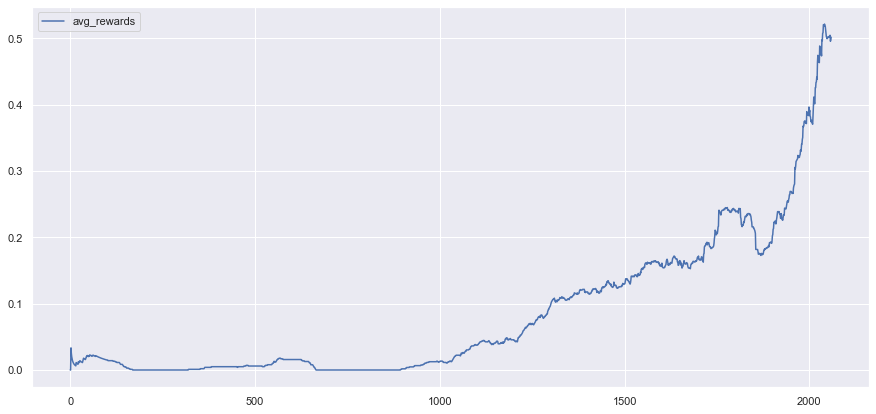

In [32]:
sns.lineplot(data=df_rewards[0:2060])